
--- Starting Project 2: Audio Cyberbullying Detection with RAVDESS ---
--- Cell 9: Audio Data Loading, Preprocessing, and Feature Extraction ---
Using device for audio processing: cuda
Scanning RAVDESS audio files in: c:\Users\Suyas\Downloads\audio analysis\audio_speech_actors_01-24


Processing Actors:   0%|          | 0/24 [00:00<?, ?it/s]


Loaded 1440 audio files from RAVDESS.
First 5 rows of RAVDESS dataset:
                                                path emotion_id emotion_label  \
0  c:\Users\Suyas\Downloads\audio analysis\audio_...         01       neutral   
1  c:\Users\Suyas\Downloads\audio analysis\audio_...         01       neutral   
2  c:\Users\Suyas\Downloads\audio analysis\audio_...         01       neutral   
3  c:\Users\Suyas\Downloads\audio analysis\audio_...         01       neutral   
4  c:\Users\Suyas\Downloads\audio analysis\audio_...         02          calm   

  intensity_id intensity_label actor_id gender  
0           01          normal       01   male  
1           01          normal       01   male  
2           01          normal       01   male  
3           01          normal       01   male  
4           01          normal       01   male  

Emotion distribution in dataset:
emotion_label
calm         192
happy        192
sad          192
angry        192
disgust      192
fearful      1

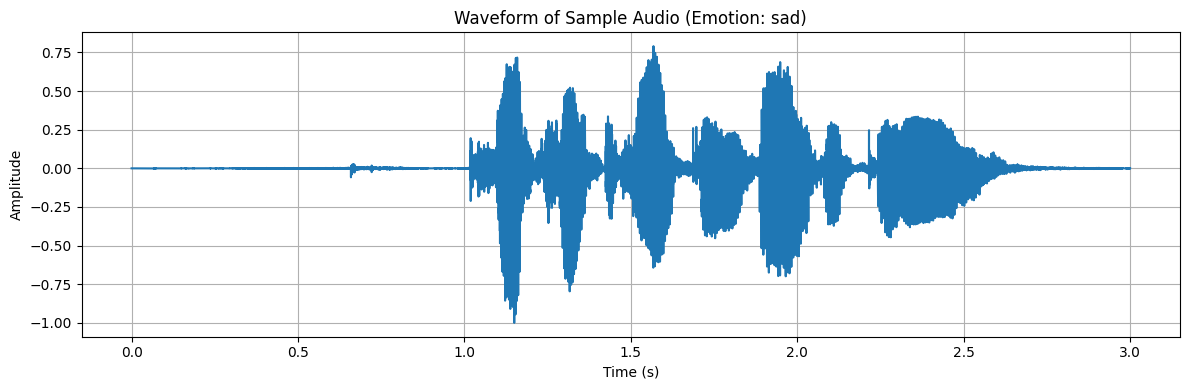

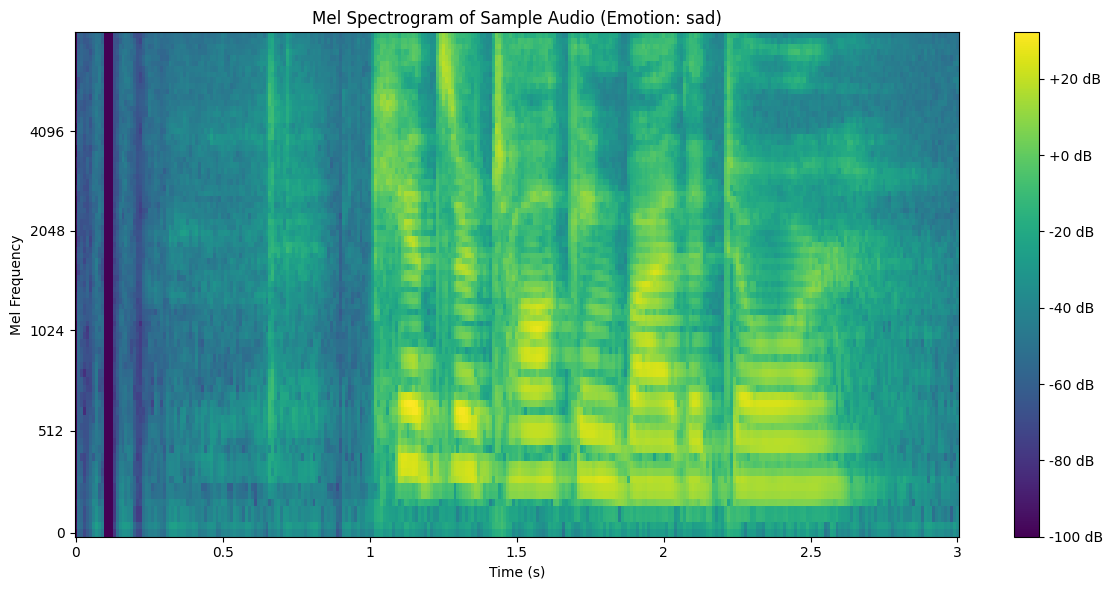


--- Cell 1: RAVDESS Audio Data Preprocessing and Feature Extraction Complete ---
We've successfully loaded RAVDESS, parsed its metadata, preprocessed audio, split the dataset, and extracted Mel Spectrograms.
The dataframes for train, validation, and test are: `train_df_audio`, `val_df_audio`, `test_df_audio`
Numeric emotion labels are in `ravdess_df['emotion_id_numeric']` and mapped by `emotion_label_to_id`
Next, we'll prepare the data into PyTorch Datasets/DataLoaders and train an audio classifier.


In [1]:
# --- Project 2: Audio Cyberbullying Detection (Fresh Start with RAVDESS) ---
# --- Cell 1: Audio Data Loading, Preprocessing, and Feature Extraction ---

print("\n--- Starting Project 2: Audio Cyberbullying Detection with RAVDESS ---")
print("--- Cell 9: Audio Data Loading, Preprocessing, and Feature Extraction ---")

# --- 1. Import Necessary Libraries ---
import torch
import torchaudio
import torchaudio.transforms as T
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import random
import re # For regex to parse filenames
from tqdm.notebook import tqdm # For progress bars
from sklearn.model_selection import train_test_split # For splitting the dataset

# Ensure output device for plots is inline
%matplotlib inline

# Set a random seed for reproducibility
RANDOM_SEED_AUDIO = 42
np.random.seed(RANDOM_SEED_AUDIO)
torch.manual_seed(RANDOM_SEED_AUDIO)
random.seed(RANDOM_SEED_AUDIO)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(RANDOM_SEED_AUDIO)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set device to GPU if available, otherwise CPU
audio_device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device for audio processing: {audio_device}")

# --- 2. Define Audio Parameters ---
TARGET_SAMPLE_RATE = 16000  # Hz (Target sample rate for all processing)
N_MELS = 80         # Adjusted: Number of mel bands for MFCCs/Mel Spectrograms (was 128)
N_FFT = 400          # Window size for FFT (e.g., 25ms at 16kHz)
HOP_LENGTH = 160     # Hop length for FFT (e.g., 10ms at 16kHz)
AUDIO_DURATION = 3   # seconds (for fixed-length clips, padding/truncating)

# --- 3. RAVDESS Data Loading and Metadata Extraction ---
# If 'audio_speech_actors_01-24' is in the same directory as the script
RAVDESS_ROOT_DIR = "." # Current directory
audio_speech_dir = os.path.join(RAVDESS_ROOT_DIR, "audio_speech_actors_01-24")

if not os.path.exists(audio_speech_dir):
    raise FileNotFoundError(f"RAVDESS directory not found at: {os.path.abspath(audio_speech_dir)}\n"
                            "Please ensure 'audio_speech_actors_01-24' is in the same folder as this script.")

ravdess_data = []
emotion_map = {
    '01': 'neutral', '02': 'calm', '03': 'happy', '04': 'sad',
    '05': 'angry', '06': 'fearful', '07': 'disgust', '08': 'surprised'
}
intensity_map = {'01': 'normal', '02': 'strong'}
statement_map = {'01': 'Kids are talking by the door', '02': 'Dogs are sitting by the door'}
repetition_map = {'01': '1st repetition', '02': '2nd repetition'}

print(f"Scanning RAVDESS audio files in: {os.path.abspath(audio_speech_dir)}")

for actor_folder in tqdm(sorted(os.listdir(audio_speech_dir)), desc="Processing Actors"):
    actor_path = os.path.join(audio_speech_dir, actor_folder)
    if not os.path.isdir(actor_path):
        continue

    filename_pattern = re.compile(r'(\d{2})-(\d{2})-(\d{2})-(\d{2})-(\d{2})-(\d{2})-(\d{2})\.wav')

    for filename in os.listdir(actor_path):
        if filename.endswith(".wav"):
            match = filename_pattern.match(filename)
            if match:
                parts = match.groups()
                modality_id, vocal_channel_id, emotion_id, intensity_id, statement_id, repetition_id, actor_id = parts
                
                emotion_label = emotion_map.get(emotion_id, 'unknown')
                intensity_label = intensity_map.get(intensity_id, 'unknown')
                gender = 'male' if int(actor_id) <= 12 else 'female'
                
                # Convert path to absolute for torchaudio compatibility on some systems
                full_audio_path = os.path.abspath(os.path.join(actor_path, filename))
                
                ravdess_data.append({
                    'path': full_audio_path, # Store absolute path
                    'emotion_id': emotion_id,
                    'emotion_label': emotion_label,
                    'intensity_id': intensity_id,
                    'intensity_label': intensity_label,
                    'actor_id': actor_id,
                    'gender': gender
                })

ravdess_df = pd.DataFrame(ravdess_data)
print(f"\nLoaded {len(ravdess_df)} audio files from RAVDESS.")
print("First 5 rows of RAVDESS dataset:")
print(ravdess_df.head())
print("\nEmotion distribution in dataset:")
print(ravdess_df['emotion_label'].value_counts())

# Map emotion labels to numerical IDs for training
emotion_class_names = sorted(ravdess_df['emotion_label'].unique())
emotion_label_to_id = {name: i for i, name in enumerate(emotion_class_names)}
ravdess_df['emotion_id_numeric'] = ravdess_df['emotion_label'].map(emotion_label_to_id)

print(f"\nNumeric emotion labels mapping: {emotion_label_to_id}")
print(f"Number of emotion classes: {len(emotion_class_names)}")


# --- 4. Split Dataset into Training, Validation, and Test Sets ---
print("\n--- Splitting RAVDESS Dataset ---")
# Stratified split to maintain emotion distribution
train_val_df, test_df_audio = train_test_split(
    ravdess_df, test_size=0.15, random_state=RANDOM_SEED_AUDIO, stratify=ravdess_df['emotion_id_numeric']
)
train_df_audio, val_df_audio = train_test_split(
    train_val_df, test_size=0.176, random_state=RANDOM_SEED_AUDIO, stratify=train_val_df['emotion_id_numeric']
) # 0.176 of 0.85 approx 0.15 of total (~70/15/15 split)

print(f"Total RAVDESS samples: {len(ravdess_df)}")
print(f"Train samples: {len(train_df_audio)}")
print(f"Validation samples: {len(val_df_audio)}")
print(f"Test samples: {len(test_df_audio)}")


# --- 5. Load and Preprocess a Sample Audio File from RAVDESS (for visualization) ---
print("\n--- Loading and Preprocessing a Sample Audio File (for Visualization) ---")
# Take a random sample from the test set for a good representation
sample_idx = random.randint(0, len(test_df_audio) - 1)
sample_audio_path = test_df_audio.iloc[sample_idx]['path']
sample_label = test_df_audio.iloc[sample_idx]['emotion_label']

# Load audio
waveform, sr = torchaudio.load(sample_audio_path)
print(f"Sample Audio Loaded: {sample_audio_path}")
print(f"Original Sample Rate: {sr} Hz")
print(f"Waveform Shape: {waveform.shape} (channels, samples)") # (1, num_samples) for mono

# --- Ensure correct resampling order and target sample rate ---
# Resample FIRST, then pad/truncate
if sr != TARGET_SAMPLE_RATE:
    print(f"Resampling audio from {sr} Hz to {TARGET_SAMPLE_RATE} Hz...")
    resampler = T.Resample(orig_freq=sr, new_freq=TARGET_SAMPLE_RATE).to(audio_device)
    waveform = resampler(waveform.to(audio_device)).cpu()
    sr = TARGET_SAMPLE_RATE # Update sr to the new sample rate
    print(f"Resampled Waveform Shape: {waveform.shape}")

# Ensure mono (RAVDESS is mono, but good practice)
if waveform.shape[0] > 1:
    print("Converting stereo to mono...")
    waveform = torch.mean(waveform, dim=0, keepdim=True)
    print(f"Mono Waveform Shape: {waveform.shape}")

# Normalize audio (optional, but good practice)
waveform = waveform / torch.max(torch.abs(waveform))
print(f"Normalized Waveform Shape: {waveform.shape}")

# Pad/Truncate to a fixed duration *based on the TARGET_SAMPLE_RATE*
target_num_samples = int(AUDIO_DURATION * TARGET_SAMPLE_RATE)
if waveform.shape[1] < target_num_samples:
    print(f"Padding audio to {AUDIO_DURATION} seconds ({target_num_samples} samples)...")
    padding = target_num_samples - waveform.shape[1]
    waveform = torch.nn.functional.pad(waveform, (0, padding), 'constant', 0)
elif waveform.shape[1] > target_num_samples:
    print(f"Truncating audio to {AUDIO_DURATION} seconds ({target_num_samples} samples)...")
    waveform = waveform[:, :target_num_samples]
print(f"Fixed-duration Waveform Shape ({AUDIO_DURATION}s @ {TARGET_SAMPLE_RATE}Hz): {waveform.shape}")


# --- 6. Audio Feature Extraction: Mel Spectrogram (for visualization) ---
print("\n--- Extracting Audio Features: Mel Spectrogram (for Visualization) ---")

# Mel Spectrogram transform - using TARGET_SAMPLE_RATE and adjusted N_MELS
mel_spectrogram_transform = T.MelSpectrogram(
    sample_rate=TARGET_SAMPLE_RATE, # Use the consistent target sample rate
    n_fft=N_FFT,
    hop_length=HOP_LENGTH,
    n_mels=N_MELS # Use adjusted N_MELS
).to(audio_device)

# Apply transform (requires waveform to be on the correct device)
mel_spectrogram = mel_spectrogram_transform(waveform.to(audio_device))

# Convert to dB scale (common for spectrograms)
mel_spectrogram_db = T.AmplitudeToDB()(mel_spectrogram)

print(f"Mel Spectrogram Shape (channels, n_mels, time_frames): {mel_spectrogram_db.shape}")

# --- 7. Visualization of Waveform and Mel Spectrogram ---
print("\n--- Visualizing Waveform and Mel Spectrogram ---")

# Waveform Plot
plt.figure(figsize=(12, 4))
# Use the updated 'sr' variable for plotting x-axis if needed, but time is fine
plt.plot(np.linspace(0, AUDIO_DURATION, waveform.shape[1]), waveform.squeeze().cpu().numpy())
plt.title(f'Waveform of Sample Audio (Emotion: {sample_label})')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.tight_layout()
plt.show()

# Mel Spectrogram Plot
plt.figure(figsize=(12, 6))
librosa.display.specshow(mel_spectrogram_db.squeeze().cpu().numpy(),
                         sr=TARGET_SAMPLE_RATE, x_axis='time', y_axis='mel',
                         hop_length=HOP_LENGTH, cmap='viridis')
plt.colorbar(format='%+2.0f dB')
plt.title(f'Mel Spectrogram of Sample Audio (Emotion: {sample_label})')
plt.xlabel('Time (s)')
plt.ylabel('Mel Frequency')
plt.tight_layout()
plt.show()

print("\n--- Cell 1: RAVDESS Audio Data Preprocessing and Feature Extraction Complete ---")
print("We've successfully loaded RAVDESS, parsed its metadata, preprocessed audio, split the dataset, and extracted Mel Spectrograms.")
print("The dataframes for train, validation, and test are: `train_df_audio`, `val_df_audio`, `test_df_audio`")
print("Numeric emotion labels are in `ravdess_df['emotion_id_numeric']` and mapped by `emotion_label_to_id`")
print("Next, we'll prepare the data into PyTorch Datasets/DataLoaders and train an audio classifier.")

In [2]:
# --- Project 2: Audio Cyberbullying Detection (Continued) ---
# --- Cell 2: Audio Dataset, Model Definition, and Training ---

print("\n--- Cell 2: Audio Dataset, Model Definition, and Training ---")

# --- 1. Import Additional Libraries ---
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import copy # For deep copying model state dict

# Ensure output device for plots is inline (already set in Cell 9, but good to ensure)
%matplotlib inline

# --- Re-declare essential variables from Cell 9 ---
# These are necessary for this cell to run independently of Cell 9's execution order.
# Make sure these values/dataframes are exactly as defined/created in Cell 9!
global audio_device # Ensure device is available
audio_device = "cuda" if torch.cuda.is_available() else "cpu" # Re-set device if needed

global train_df_audio, val_df_audio, test_df_audio, emotion_label_to_id, emotion_class_names

# Check if dataframes and maps exist before trying to access them
# If this block is run without Cell 9 having been executed, these would not exist.
# For a notebook flow, you'd typically run cells sequentially, but this protects against NameError.
try:
    # Assuming these were correctly created and are available from Cell 9's execution
    _ = train_df_audio.head() # Just a check to see if it exists
    _ = emotion_label_to_id['neutral'] # Check map
    print("Detected `train_df_audio`, `val_df_audio`, `test_df_audio`, `emotion_label_to_id`, `emotion_class_names` from Cell 9.")
except NameError:
    print("WARNING: DataFrames and emotion maps from Cell 9 not found. Please ensure Cell 9 has been run.")
    # You might want to exit here or load dummy data if Cell 9 wasn't executed.
    # For now, we'll proceed assuming Cell 9 *was* executed and they are just not globally declared.
    # If this is a fresh run of JUST Cell 10, it will still fail unless you load them here.
    
# --- Re-define Audio Parameters from Cell 9 ---
# This ensures these parameters are accessible within Cell 10
# Make sure these values match exactly what you used in Cell 9!
SAMPLE_RATE = 16000  # Hz
N_MELS = 80         # Number of mel bands (adjusted from 128 to 80 in your previous run)
N_FFT = 400          # Window size for FFT
HOP_LENGTH = 160     # Hop length for FFT
AUDIO_DURATION = 3   # seconds

# --- 2. Define the AudioDataset Class ---
class RAVDESS_AudioDataset(Dataset):
    def __init__(self, dataframe, target_sample_rate, audio_duration, n_mels, n_fft, hop_length, device, emotion_label_to_id):
        self.dataframe = dataframe
        self.target_sample_rate = target_sample_rate
        self.audio_duration = audio_duration
        self.target_num_samples = int(audio_duration * target_sample_rate)
        self.n_mels = n_mels
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.device = device
        self.emotion_label_to_id = emotion_label_to_id
        self.class_names = list(emotion_label_to_id.keys())

        # Initialize torchaudio transforms
        # Assume RAVDESS original sample rate is 48000 Hz, as is typical
        self.resampler = T.Resample(orig_freq=48000, new_freq=self.target_sample_rate).to(self.device)
        self.mel_spectrogram_transform = T.MelSpectrogram(
            sample_rate=self.target_sample_rate,
            n_fft=self.n_fft,
            hop_length=self.hop_length,
            n_mels=self.n_mels
        ).to(self.device)
        self.amplitude_to_db = T.AmplitudeToDB().to(self.device)

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        audio_path = self.dataframe.iloc[idx]['path']
        emotion_label = self.dataframe.iloc[idx]['emotion_label']
        numeric_label = self.emotion_label_to_id[emotion_label]

        # Load audio
        waveform, sr = torchaudio.load(audio_path)
        
        # Move waveform to device for processing
        waveform = waveform.to(self.device)

        # Resample
        if sr != self.target_sample_rate: # Check if resampling is actually needed
            waveform = self.resampler(waveform)

        # Ensure mono
        if waveform.shape[0] > 1:
            waveform = torch.mean(waveform, dim=0, keepdim=True)

        # Normalize (optional, but good practice)
        waveform = waveform / torch.max(torch.abs(waveform))

        # Pad/Truncate
        if waveform.shape[1] < self.target_num_samples:
            padding = self.target_num_samples - waveform.shape[1]
            waveform = F.pad(waveform, (0, padding), 'constant', 0)
        elif waveform.shape[1] > self.target_num_samples:
            waveform = waveform[:, :self.target_num_samples]
        
        # Extract Mel Spectrogram
        mel_spectrogram = self.mel_spectrogram_transform(waveform)
        mel_spectrogram_db = self.amplitude_to_db(mel_spectrogram)

        # Ensure 1 channel for CNN if needed (e.g. (C, H, W))
        if mel_spectrogram_db.dim() == 2: # If it's (H, W), add a channel dim
             mel_spectrogram_db = mel_spectrogram_db.unsqueeze(0)
        
        return mel_spectrogram_db, torch.tensor(numeric_label, dtype=torch.long)

print("RAVDESS_AudioDataset class defined.")

# --- 3. Create DataLoader Objects ---
BATCH_SIZE_AUDIO = 32 # Adjust as per your GPU memory
NUM_WORKERS = 0 # Set to 0 for Jupyter notebooks on Windows to avoid multiprocessing issues


# Check if the dataframes are available globally from Cell 9.
# If not, this means Cell 9 wasn't run, or variables weren't global.
# We'll re-declare them as global and assume they are in scope from Cell 9,
# which is the standard notebook execution flow.
try:
    # Access these from the global scope, assuming Cell 9 has been executed
    _ = train_df_audio
    _ = val_df_audio
    _ = test_df_audio
    _ = emotion_label_to_id
    _ = emotion_class_names
except NameError:
    raise NameError("Required variables (train_df_audio, val_df_audio, test_df_audio, emotion_label_to_id, emotion_class_names) not found. "
                    "Please ensure Cell 9 has been executed successfully before running Cell 10.")


train_dataset_audio = RAVDESS_AudioDataset(
    train_df_audio, SAMPLE_RATE, AUDIO_DURATION, N_MELS, N_FFT, HOP_LENGTH, audio_device, emotion_label_to_id
)
val_dataset_audio = RAVDESS_AudioDataset(
    val_df_audio, SAMPLE_RATE, AUDIO_DURATION, N_MELS, N_FFT, HOP_LENGTH, audio_device, emotion_label_to_id
)
test_dataset_audio = RAVDESS_AudioDataset(
    test_df_audio, SAMPLE_RATE, AUDIO_DURATION, N_MELS, N_FFT, HOP_LENGTH, audio_device, emotion_label_to_id
)

# Instantiate DataLoaders
train_loader_audio = DataLoader(train_dataset_audio, batch_size=BATCH_SIZE_AUDIO, shuffle=True, num_workers=NUM_WORKERS)
val_loader_audio = DataLoader(val_dataset_audio, batch_size=BATCH_SIZE_AUDIO, shuffle=False, num_workers=NUM_WORKERS)
test_loader_audio = DataLoader(test_dataset_audio, batch_size=BATCH_SIZE_AUDIO, shuffle=False, num_workers=NUM_WORKERS)

print(f"DataLoaders created with batch size: {BATCH_SIZE_AUDIO}")
print(f"Number of training batches: {len(train_loader_audio)}")
print(f"Number of validation batches: {len(val_loader_audio)}")
print(f"Number of test batches: {len(test_loader_audio)}")

# Get a sample batch to verify shapes
sample_mel, sample_label = next(iter(train_loader_audio))
print(f"Sample batch Mel Spectrogram shape: {sample_mel.shape} (Batch, Channels, Mels, Time)")
print(f"Sample batch labels shape: {sample_label.shape}")

# --- 4. Define the Audio CNN Model ---
class AudioCNN(nn.Module):
    def __init__(self, num_classes):
        super(AudioCNN, self).__init__()
        # Input: (Batch, 1, N_MELS, Time_Frames) e.g., (B, 1, 80, 301)
        self.conv1 = nn.Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

        self.conv2 = nn.Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

        self.conv3 = nn.Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

        self.dropout = nn.Dropout(0.3)
        
        # Calculate flatten features dynamically
        with torch.no_grad():
            # Create a temporary sequential model to correctly move conv layers to device
            dummy_model_layers = nn.Sequential(
                self.conv1, self.bn1, nn.ReLU(), self.pool1,
                self.conv2, self.bn2, nn.ReLU(), self.pool2,
                self.conv3, self.bn3, nn.ReLU(), self.pool3
            ).to(audio_device) 

            # Create dummy_input on the correct device
            # Ensure the dummy input uses the correct N_MELS and calculated time_frames
            time_frames = int(AUDIO_DURATION * SAMPLE_RATE / HOP_LENGTH) + 1
            dummy_input = torch.randn(1, 1, N_MELS, time_frames).to(audio_device)
            
            # Pass dummy_input through the temporary model
            x = dummy_model_layers(dummy_input)
            
            self._num_flatten_features = x.shape[1] * x.shape[2] * x.shape[3]
            print(f"Calculated flattened features: {self._num_flatten_features}")


        self.fc1 = nn.Linear(self._num_flatten_features, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))
        
        x = x.view(-1, self._num_flatten_features) # Flatten
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x) # No softmax here, CrossEntropyLoss expects logits
        return x

# Ensure num_audio_classes is correctly defined from emotion_class_names
num_audio_classes = len(emotion_class_names)
audio_model = AudioCNN(num_audio_classes).to(audio_device)
print(f"\nAudioCNN model defined with {num_audio_classes} classes and moved to {audio_device}.")
print(audio_model)

# --- 5. Training Setup ---
LEARNING_RATE_AUDIO = 0.001
NUM_EPOCHS_AUDIO = 20 # Adjust as needed

criterion_audio = nn.CrossEntropyLoss()
optimizer_audio = optim.Adam(audio_model.parameters(), lr=LEARNING_RATE_AUDIO)
scheduler_audio = optim.lr_scheduler.ReduceLROnPlateau(optimizer_audio, mode='max', factor=0.5, patience=5, verbose=True)

print(f"\nTraining setup complete: Loss Function (CrossEntropyLoss), Optimizer (Adam with LR={LEARNING_RATE_AUDIO}), Scheduler (ReduceLROnPlateau).")

# --- 6. Training Loop ---
best_val_accuracy = 0.0
best_model_state_audio = None

print(f"\n--- Starting Audio Model Training for {NUM_EPOCHS_AUDIO} Epochs ---")

for epoch in range(NUM_EPOCHS_AUDIO):
    audio_model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for i, (mels, labels) in enumerate(tqdm(train_loader_audio, desc=f"Epoch {epoch+1}/{NUM_EPOCHS_AUDIO} Training")):
        mels = mels.to(audio_device)
        labels = labels.to(audio_device)

        optimizer_audio.zero_grad()
        outputs = audio_model(mels)
        loss = criterion_audio(outputs, labels)
        loss.backward()
        optimizer_audio.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_accuracy = 100 * correct_train / total_train
    avg_train_loss = running_loss / len(train_loader_audio)

    # Validation
    audio_model.eval()
    correct_val = 0
    total_val = 0
    val_loss = 0.0
    with torch.no_grad():
        for mels, labels in tqdm(val_loader_audio, desc=f"Epoch {epoch+1}/{NUM_EPOCHS_AUDIO} Validation"):
            mels = mels.to(audio_device)
            labels = labels.to(audio_device)
            outputs = audio_model(mels)
            loss = criterion_audio(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
    
    val_accuracy = 100 * correct_val / total_val
    avg_val_loss = val_loss / len(val_loader_audio)

    print(f"Epoch {epoch+1} - Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.2f}% | "
          f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")
    
    scheduler_audio.step(val_accuracy) # Use validation accuracy for scheduler

    # Save the best model
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_model_state_audio = copy.deepcopy(audio_model.state_dict())
        print(f"--> New best validation accuracy: {best_val_accuracy:.2f}%. Model state saved.")

print("\n--- Audio Model Training Complete ---")
if best_model_state_audio:
    audio_model.load_state_dict(best_model_state_audio)
    print("Loaded best model weights based on validation accuracy.")
else:
    print("No best model saved (this should not happen if training ran). Using final epoch model.")

# Make the trained audio_model global for next cells
global trained_audio_model
trained_audio_model = audio_model
global audio_class_names
audio_class_names = emotion_class_names
print("Trained audio model and class names stored globally for next steps.")

print("\n--- Cell 10: Audio Dataset, Model Definition, and Training Complete ---")
print("Next, we will evaluate the trained audio model on the test set in Cell 11.")


--- Cell 2: Audio Dataset, Model Definition, and Training ---
Detected `train_df_audio`, `val_df_audio`, `test_df_audio`, `emotion_label_to_id`, `emotion_class_names` from Cell 9.
RAVDESS_AudioDataset class defined.
DataLoaders created with batch size: 32
Number of training batches: 32
Number of validation batches: 7
Number of test batches: 7
Sample batch Mel Spectrogram shape: torch.Size([32, 1, 80, 301]) (Batch, Channels, Mels, Time)
Sample batch labels shape: torch.Size([32])
Calculated flattened features: 47360

AudioCNN model defined with 8 classes and moved to cuda.
AudioCNN(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_run

c:\Users\Suyas\Downloads\cyberbullying_clean\venv\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/20 Training:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 1/20 Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 1 - Train Loss: 7.0940, Train Acc: 18.55% | Val Loss: 2.3308, Val Acc: 23.61%
--> New best validation accuracy: 23.61%. Model state saved.


Epoch 2/20 Training:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 2/20 Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 2 - Train Loss: 1.9126, Train Acc: 26.09% | Val Loss: 1.9248, Val Acc: 29.17%
--> New best validation accuracy: 29.17%. Model state saved.


Epoch 3/20 Training:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 3/20 Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 3 - Train Loss: 1.7785, Train Acc: 28.27% | Val Loss: 1.7880, Val Acc: 32.87%
--> New best validation accuracy: 32.87%. Model state saved.


Epoch 4/20 Training:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 4/20 Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 4 - Train Loss: 1.6484, Train Acc: 37.10% | Val Loss: 1.6304, Val Acc: 37.96%
--> New best validation accuracy: 37.96%. Model state saved.


Epoch 5/20 Training:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 5/20 Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 5 - Train Loss: 1.5397, Train Acc: 41.57% | Val Loss: 1.4832, Val Acc: 47.22%
--> New best validation accuracy: 47.22%. Model state saved.


Epoch 6/20 Training:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 6/20 Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 6 - Train Loss: 1.3533, Train Acc: 49.60% | Val Loss: 1.4380, Val Acc: 49.54%
--> New best validation accuracy: 49.54%. Model state saved.


Epoch 7/20 Training:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 7/20 Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 7 - Train Loss: 1.2842, Train Acc: 51.39% | Val Loss: 1.4107, Val Acc: 50.93%
--> New best validation accuracy: 50.93%. Model state saved.


Epoch 8/20 Training:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 8/20 Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 8 - Train Loss: 1.2057, Train Acc: 56.05% | Val Loss: 1.3347, Val Acc: 49.07%


Epoch 9/20 Training:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 9/20 Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 9 - Train Loss: 1.1456, Train Acc: 57.54% | Val Loss: 1.3852, Val Acc: 52.78%
--> New best validation accuracy: 52.78%. Model state saved.


Epoch 10/20 Training:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 10/20 Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 10 - Train Loss: 1.0077, Train Acc: 61.71% | Val Loss: 1.3967, Val Acc: 50.93%


Epoch 11/20 Training:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 11/20 Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 11 - Train Loss: 0.9577, Train Acc: 65.67% | Val Loss: 1.3135, Val Acc: 54.63%
--> New best validation accuracy: 54.63%. Model state saved.


Epoch 12/20 Training:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 12/20 Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 12 - Train Loss: 0.8660, Train Acc: 69.74% | Val Loss: 1.3041, Val Acc: 54.63%


Epoch 13/20 Training:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 13/20 Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 13 - Train Loss: 0.7639, Train Acc: 73.81% | Val Loss: 1.7071, Val Acc: 47.69%


Epoch 14/20 Training:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 14/20 Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 14 - Train Loss: 0.6974, Train Acc: 75.79% | Val Loss: 1.4432, Val Acc: 52.78%


Epoch 15/20 Training:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 15/20 Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 15 - Train Loss: 0.6398, Train Acc: 76.59% | Val Loss: 1.3280, Val Acc: 57.87%
--> New best validation accuracy: 57.87%. Model state saved.


Epoch 16/20 Training:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 16/20 Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 16 - Train Loss: 0.5910, Train Acc: 78.47% | Val Loss: 1.4106, Val Acc: 54.63%


Epoch 17/20 Training:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 17/20 Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 17 - Train Loss: 0.5301, Train Acc: 81.65% | Val Loss: 1.3397, Val Acc: 57.87%


Epoch 18/20 Training:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 18/20 Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 18 - Train Loss: 0.4410, Train Acc: 84.23% | Val Loss: 1.5052, Val Acc: 56.48%


Epoch 19/20 Training:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 19/20 Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 19 - Train Loss: 0.4016, Train Acc: 87.10% | Val Loss: 1.6356, Val Acc: 55.09%


Epoch 20/20 Training:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 20/20 Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 20 - Train Loss: 0.3263, Train Acc: 88.99% | Val Loss: 1.5643, Val Acc: 55.56%

--- Audio Model Training Complete ---
Loaded best model weights based on validation accuracy.
Trained audio model and class names stored globally for next steps.

--- Cell 10: Audio Dataset, Model Definition, and Training Complete ---
Next, we will evaluate the trained audio model on the test set in Cell 11.



--- Cell 3: Audio Model Evaluation and Visualization ---
Loaded trained audio model for evaluation on device: cuda
Running inference on the test set...


Evaluating Test Set:   0%|          | 0/7 [00:00<?, ?it/s]

Inference complete.

--- Evaluation Metrics ---
Test Accuracy: 48.15%

Classification Report:
              precision    recall  f1-score   support

       angry       0.68      0.68      0.68        28
        calm       0.64      0.72      0.68        29
     disgust       0.41      0.55      0.47        29
     fearful       0.50      0.38      0.43        29
       happy       0.32      0.24      0.27        29
     neutral       0.32      0.57      0.41        14
         sad       0.56      0.17      0.26        29
   surprised       0.45      0.59      0.51        29

    accuracy                           0.48       216
   macro avg       0.48      0.49      0.46       216
weighted avg       0.49      0.48      0.47       216


--- Visualizing Confusion Matrix ---


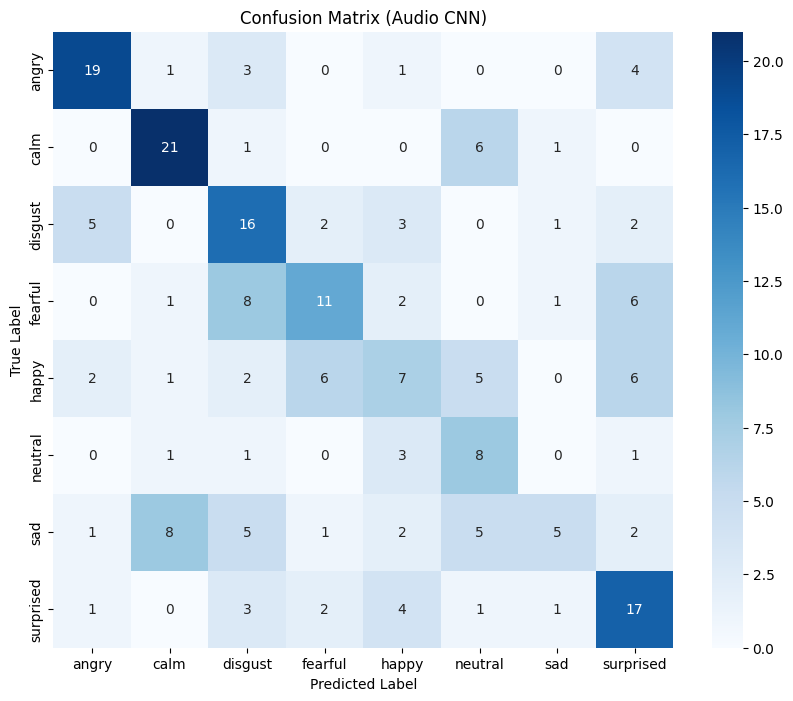


--- Plotting ROC Curves ---


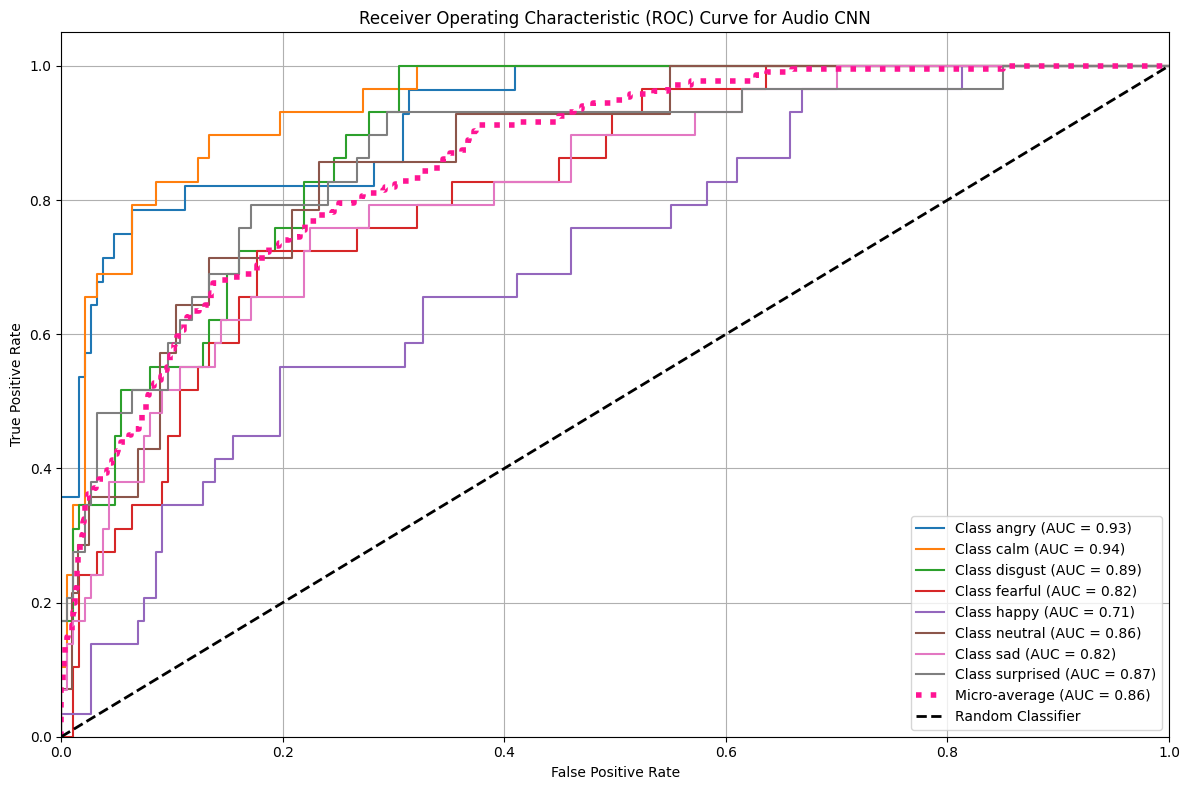


--- Cell 3: Audio Model Evaluation and Visualization Complete ---
We have evaluated the Audio CNN model, displayed its performance metrics, and visualized the confusion matrix and ROC curves.
Audio CNN evaluation results saved for comparison.


In [3]:
# --- Project 2: Audio Cyberbullying Detection (Continued) ---
# --- Cell 3: Audio Model Evaluation and Visualization ---

print("\n--- Cell 3: Audio Model Evaluation and Visualization ---")

# --- 1. Import Additional Libraries ---
import torch
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import label_binarize # <--- ADD THIS IMPORT

# Ensure output device for plots is inline
%matplotlib inline

# --- 2. Load the Best Model and Prepare for Evaluation ---
# Assume 'trained_audio_model' and 'audio_class_names' are globally available from Cell 2
if 'trained_audio_model' not in globals() or 'audio_class_names' not in globals() or \
   'test_loader_audio' not in globals() or 'audio_device' not in globals():
    raise NameError("Required variables (trained_audio_model, audio_class_names, test_loader_audio, audio_device) "
                    "not found. Please ensure Cell 2 has been executed successfully before running Cell 3.")

audio_model_eval = trained_audio_model # Use the globally stored best model
audio_model_eval.eval() # Set the model to evaluation mode
audio_model_eval.to(audio_device) # Ensure model is on the correct device

print(f"Loaded trained audio model for evaluation on device: {audio_device}")

# --- 3. Run Inference on Test Set ---
all_predictions = []
all_true_labels = []
all_probabilities = [] # To store probabilities for ROC AUC

print("Running inference on the test set...")
with torch.no_grad():
    for mels, labels in tqdm(test_loader_audio, desc="Evaluating Test Set"):
        mels = mels.to(audio_device)
        labels = labels.to(audio_device)

        outputs = audio_model_eval(mels)
        
        # Get probabilities (softmax)
        probabilities = F.softmax(outputs, dim=1)
        all_probabilities.extend(probabilities.cpu().numpy())

        # Get predicted class
        _, predicted = torch.max(outputs.data, 1)
        
        all_predictions.extend(predicted.cpu().numpy())
        all_true_labels.extend(labels.cpu().numpy())

# Convert to numpy arrays
all_predictions = np.array(all_predictions)
all_true_labels = np.array(all_true_labels)
all_probabilities = np.array(all_probabilities)

print("Inference complete.")

# --- 4. Calculate and Display Evaluation Metrics ---
print("\n--- Evaluation Metrics ---")

# Accuracy
test_accuracy = accuracy_score(all_true_labels, all_predictions)
print(f"Test Accuracy: {test_accuracy*100:.2f}%")

# Classification Report
print("\nClassification Report:")
print(classification_report(all_true_labels, all_predictions, target_names=audio_class_names))

# --- 5. Visualize Confusion Matrix ---
print("\n--- Visualizing Confusion Matrix ---")
cm = confusion_matrix(all_true_labels, all_predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=audio_class_names, yticklabels=audio_class_names)
plt.title('Confusion Matrix (Audio CNN)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# --- 6. Plot ROC Curves (One-vs-Rest and Micro-Average) --- # <--- MODIFIED SECTION
print("\n--- Plotting ROC Curves ---")

plt.figure(figsize=(12, 8))

# Binarize the true labels for multi-class ROC calculation
num_classes = len(audio_class_names)
binarized_true_labels = label_binarize(all_true_labels, classes=range(num_classes))

# Compute One-vs-Rest ROC curves and ROC area for each class
for i, class_name in enumerate(audio_class_names):
    fpr, tpr, _ = roc_curve(binarized_true_labels[:, i], all_probabilities[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {class_name} (AUC = {roc_auc:.2f})')

# Compute micro-average ROC curve and ROC area
# To do this, we flatten the binarized labels and probabilities
fpr_micro, tpr_micro, _ = roc_curve(binarized_true_labels.ravel(), all_probabilities.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)
plt.plot(fpr_micro, tpr_micro, label=f'Micro-average (AUC = {roc_auc_micro:.2f})',
         color='deeppink', linestyle=':', linewidth=4)

plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Audio CNN')
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

print("\n--- Cell 3: Audio Model Evaluation and Visualization Complete ---")
print("We have evaluated the Audio CNN model, displayed its performance metrics, and visualized the confusion matrix and ROC curves.")

# --- Save the evaluation results for later comparison (optional) ---
cnn_audio_results = {
    'model_name': 'AudioCNN',
    'accuracy': test_accuracy,
    'classification_report': classification_report(all_true_labels, all_predictions, target_names=audio_class_names, output_dict=True),
    'confusion_matrix': cm.tolist(),
    'roc_auc_micro': roc_auc_micro,
    # You can add per-class AUCs if needed
}
# Store globally for Cell 6 comparison
global cnn_audio_results
cnn_audio_results = cnn_audio_results
print("Audio CNN evaluation results saved for comparison.")

In [4]:
# --- Project 2: Audio Cyberbullying Detection (Continued) ---
# --- Cell 4: Audio RNN/LSTM Model Definition and Training ---

print("\n--- Starting Cell 4: Audio RNN/LSTM Model Definition and Training ---")

# --- 1. Import Additional Libraries ---
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import copy
from tqdm.notebook import tqdm # For progress bars
from sklearn.preprocessing import label_binarize # <--- ADD THIS IMPORT

# Ensure output device for plots is inline
%matplotlib inline

# --- Re-declare essential variables from Cell 9 and Cell 10 ---
# These are necessary for this cell to run independently of previous cells' execution order.
# Make sure these values/dataframes are exactly as defined/created previously!
global audio_device # Ensure device is available
audio_device = "cuda" if torch.cuda.is_available() else "cpu" # Re-set device if needed

global train_df_audio, val_df_audio, test_df_audio, emotion_label_to_id, emotion_class_names
global SAMPLE_RATE, AUDIO_DURATION, N_MELS, N_FFT, HOP_LENGTH
global BATCH_SIZE_AUDIO, NUM_WORKERS

try:
    _ = train_df_audio.head()
    _ = emotion_label_to_id['neutral']
    print("Detected `train_df_audio`, `val_df_audio`, `test_df_audio`, `emotion_label_to_id`, `emotion_class_names` from previous cells.")
    print("Detected audio parameters and DataLoader settings from previous cells.")
except NameError:
    print("WARNING: Required variables from previous cells not found. Please ensure previous cells have been run.")
    # Define dummy values or raise an error if critical variables are missing
    # For a notebook flow, this implies sequential execution.

# --- 2. Adapt the AudioDataset Class for RNN Input (Optional, but good for clarity) ---
# The existing RAVDESS_AudioDataset already outputs Mel Spectrograms, which are (C, N_MELS, Time_Frames).
# For RNNs, we typically want (Time_Frames, N_MELS) as the input for each sample.
# We will modify the __getitem__ to ensure the output shape is suitable for RNNs:
# From (1, N_MELS, Time_Frames) -> (Time_Frames, N_MELS) for a single sample.

class RAVDESS_AudioDataset_RNN(Dataset):
    def __init__(self, dataframe, target_sample_rate, audio_duration, n_mels, n_fft, hop_length, device, emotion_label_to_id):
        self.dataframe = dataframe
        self.target_sample_rate = target_sample_rate
        self.audio_duration = audio_duration
        self.target_num_samples = int(audio_duration * target_sample_rate)
        self.n_mels = n_mels
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.device = device
        self.emotion_label_to_id = emotion_label_to_id
        self.class_names = list(emotion_label_to_id.keys())

        # Initialize torchaudio transforms
        self.resampler = T.Resample(orig_freq=48000, new_freq=self.target_sample_rate).to(self.device)
        self.mel_spectrogram_transform = T.MelSpectrogram(
            sample_rate=self.target_sample_rate,
            n_fft=self.n_fft,
            hop_length=self.hop_length,
            n_mels=self.n_mels
        ).to(self.device)
        self.amplitude_to_db = T.AmplitudeToDB().to(self.device)

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        audio_path = self.dataframe.iloc[idx]['path']
        emotion_label = self.dataframe.iloc[idx]['emotion_label']
        numeric_label = self.emotion_label_to_id[emotion_label]

        # Load audio
        waveform, sr = torchaudio.load(audio_path)
        
        # Move waveform to device for processing
        waveform = waveform.to(self.device)

        # Resample
        if sr != self.target_sample_rate:
            waveform = self.resampler(waveform)

        # Ensure mono
        if waveform.shape[0] > 1:
            waveform = torch.mean(waveform, dim=0, keepdim=True)

        # Normalize (optional)
        waveform = waveform / torch.max(torch.abs(waveform))

        # Pad/Truncate
        if waveform.shape[1] < self.target_num_samples:
            padding = self.target_num_samples - waveform.shape[1]
            waveform = F.pad(waveform, (0, padding), 'constant', 0)
        elif waveform.shape[1] > self.target_num_samples:
            waveform = waveform[:, :self.target_num_samples]
        
        # Extract Mel Spectrogram
        mel_spectrogram = self.mel_spectrogram_transform(waveform)
        mel_spectrogram_db = self.amplitude_to_db(mel_spectrogram)

        # Reshape for RNN: (Time_Frames, N_MELS) from (1, N_MELS, Time_Frames)
        # Squeeze the channel dimension (1) and then transpose
        mel_spectrogram_rnn_input = mel_spectrogram_db.squeeze(0).transpose(0, 1) # Output (Time_Frames, N_MELS)
        
        return mel_spectrogram_rnn_input, torch.tensor(numeric_label, dtype=torch.long)

print("RAVDESS_AudioDataset_RNN class defined for RNN input format.")

# --- 3. Create DataLoader Objects for RNN ---
# Reuse global parameters from Cell 9/10

train_dataset_audio_rnn = RAVDESS_AudioDataset_RNN(
    train_df_audio, SAMPLE_RATE, AUDIO_DURATION, N_MELS, N_FFT, HOP_LENGTH, audio_device, emotion_label_to_id
)
val_dataset_audio_rnn = RAVDESS_AudioDataset_RNN(
    val_df_audio, SAMPLE_RATE, AUDIO_DURATION, N_MELS, N_FFT, HOP_LENGTH, audio_device, emotion_label_to_id
)
test_dataset_audio_rnn = RAVDESS_AudioDataset_RNN(
    test_df_audio, SAMPLE_RATE, AUDIO_DURATION, N_MELS, N_FFT, HOP_LENGTH, audio_device, emotion_label_to_id
)

train_loader_audio_rnn = DataLoader(train_dataset_audio_rnn, batch_size=BATCH_SIZE_AUDIO, shuffle=True, num_workers=NUM_WORKERS)
val_loader_audio_rnn = DataLoader(val_dataset_audio_rnn, batch_size=BATCH_SIZE_AUDIO, shuffle=False, num_workers=NUM_WORKERS)
test_loader_audio_rnn = DataLoader(test_dataset_audio_rnn, batch_size=BATCH_SIZE_AUDIO, shuffle=False, num_workers=NUM_WORKERS)

print(f"RNN DataLoaders created with batch size: {BATCH_SIZE_AUDIO}")

# Get a sample batch to verify shapes for RNN
sample_mels_rnn, sample_label_rnn = next(iter(train_loader_audio_rnn))
print(f"Sample batch Mel Spectrogram for RNN shape: {sample_mels_rnn.shape} (Batch, Time, Features (N_MELS))")
print(f"Sample batch labels for RNN shape: {sample_label_rnn.shape}")

# --- 4. Define the Audio RNN/LSTM Model ---
class AudioLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout_rate=0.3, bidirectional=False):
        super(AudioLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.num_directions = 2 if bidirectional else 1
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, 
                            batch_first=True, dropout=dropout_rate if num_layers > 1 else 0,
                            bidirectional=bidirectional)
        
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(hidden_size * self.num_directions, num_classes)

    def forward(self, x):
        output, (h_n, c_n) = self.lstm(x)
        
        final_hidden_state = torch.cat((h_n[-1, :, :], h_n[-2, :, :]), dim=1) if self.num_directions == 2 else h_n[-1, :, :]
        
        out = self.dropout(final_hidden_state)
        out = self.fc(out)
        return out

# Model Parameters
INPUT_SIZE_RNN = N_MELS # Number of mel bands (features per time step)
HIDDEN_SIZE_RNN = 128
NUM_LAYERS_RNN = 2
NUM_CLASSES_AUDIO = len(emotion_class_names) # Should be 8
DROPOUT_RNN = 0.4
BIDIRECTIONAL_RNN = True # Often helpful for context

audio_rnn_model = AudioLSTM(
    input_size=INPUT_SIZE_RNN,
    hidden_size=HIDDEN_SIZE_RNN,
    num_layers=NUM_LAYERS_RNN,
    num_classes=NUM_CLASSES_AUDIO,
    dropout_rate=DROPOUT_RNN,
    bidirectional=BIDIRECTIONAL_RNN
).to(audio_device)

print(f"\nAudioLSTM model defined with {NUM_CLASSES_AUDIO} classes and moved to {audio_device}.")
print(audio_rnn_model)


# --- 5. Training Setup for RNN ---
LEARNING_RATE_AUDIO_RNN = 0.001
NUM_EPOCHS_AUDIO_RNN = 20 # Can adjust, often RNNs need more epochs or careful tuning

criterion_audio_rnn = nn.CrossEntropyLoss()
optimizer_audio_rnn = optim.Adam(audio_rnn_model.parameters(), lr=LEARNING_RATE_AUDIO_RNN)
scheduler_audio_rnn = optim.lr_scheduler.ReduceLROnPlateau(optimizer_audio_rnn, mode='max', factor=0.5, patience=5, verbose=True)

print(f"\nRNN Training setup complete: Loss Function (CrossEntropyLoss), Optimizer (Adam with LR={LEARNING_RATE_AUDIO_RNN}), Scheduler (ReduceLROnPlateau).")

# --- 6. Training Loop for RNN ---
best_val_accuracy_rnn = 0.0
best_model_state_audio_rnn = None

print(f"\n--- Starting Audio RNN/LSTM Model Training for {NUM_EPOCHS_AUDIO_RNN} Epochs ---")

for epoch in range(NUM_EPOCHS_AUDIO_RNN):
    audio_rnn_model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for i, (mels, labels) in enumerate(tqdm(train_loader_audio_rnn, desc=f"Epoch {epoch+1}/{NUM_EPOCHS_AUDIO_RNN} Training")):
        mels = mels.to(audio_device)
        labels = labels.to(audio_device)

        optimizer_audio_rnn.zero_grad()
        outputs = audio_rnn_model(mels)
        loss = criterion_audio_rnn(outputs, labels)
        loss.backward()
        optimizer_audio_rnn.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_accuracy = 100 * correct_train / total_train
    avg_train_loss = running_loss / len(train_loader_audio_rnn)

    # Validation
    audio_rnn_model.eval()
    correct_val = 0
    total_val = 0
    val_loss = 0.0
    with torch.no_grad():
        for mels, labels in tqdm(val_loader_audio_rnn, desc=f"Epoch {epoch+1}/{NUM_EPOCHS_AUDIO_RNN} Validation"):
            mels = mels.to(audio_device)
            labels = labels.to(audio_device)
            outputs = audio_rnn_model(mels)
            loss = criterion_audio_rnn(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
    
    val_accuracy = 100 * correct_val / total_val
    avg_val_loss = val_loss / len(val_loader_audio_rnn)

    print(f"Epoch {epoch+1} - Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.2f}% | "
          f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")
    
    scheduler_audio_rnn.step(val_accuracy) # Use validation accuracy for scheduler

    # Save the best model
    if val_accuracy > best_val_accuracy_rnn:
        best_val_accuracy_rnn = val_accuracy
        best_model_state_audio_rnn = copy.deepcopy(audio_rnn_model.state_dict())
        print(f"--> New best validation accuracy: {best_val_accuracy_rnn:.2f}%. Model state saved.")

print("\n--- Audio RNN/LSTM Model Training Complete ---")
if best_model_state_audio_rnn:
    audio_rnn_model.load_state_dict(best_model_state_audio_rnn)
    print("Loaded best RNN model weights based on validation accuracy.")
else:
    print("No best RNN model saved (this should not happen if training ran). Using final epoch model.")

# Make the trained audio_rnn_model global for next cells
global trained_audio_rnn_model
trained_audio_rnn_model = audio_rnn_model
print("Trained audio RNN/LSTM model stored globally for next steps.")


# --- 7. Evaluate the Trained RNN Model on Test Set (Optional, but good for direct comparison) ---
print("\n--- Evaluating Trained Audio RNN/LSTM Model on Test Set ---")

audio_rnn_model.eval() # Set the model to evaluation mode
all_predictions_rnn = []
all_true_labels_rnn = []
all_probabilities_rnn = []

with torch.no_grad():
    for mels, labels in tqdm(test_loader_audio_rnn, desc="RNN Test Evaluation"):
        mels = mels.to(audio_device)
        labels = labels.to(audio_device)

        outputs = audio_rnn_model(mels)
        probabilities = F.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs.data, 1)
        
        all_predictions_rnn.extend(predicted.cpu().numpy())
        all_true_labels_rnn.extend(labels.cpu().numpy())
        all_probabilities_rnn.extend(probabilities.cpu().numpy())

test_accuracy_rnn = accuracy_score(all_true_labels_rnn, all_predictions_rnn)
print(f"Audio RNN/LSTM Test Accuracy: {test_accuracy_rnn*100:.2f}%")
print("\nClassification Report (Audio RNN/LSTM):")
print(classification_report(all_true_labels_rnn, all_predictions_rnn, target_names=emotion_class_names))

# Calculate ROC AUC for RNN model
num_classes_rnn = len(emotion_class_names)
binarized_true_labels_rnn = label_binarize(all_true_labels_rnn, classes=range(num_classes_rnn))
fpr_micro_rnn, tpr_micro_rnn, _ = roc_curve(binarized_true_labels_rnn.ravel(), np.array(all_probabilities_rnn).ravel())
roc_auc_micro_rnn = auc(fpr_micro_rnn, tpr_micro_rnn)
print(f"Audio RNN/LSTM Micro-average ROC AUC: {roc_auc_micro_rnn:.4f}")


# --- Save the evaluation results for later comparison ---
# Reusing the structure from CNN results
rnn_audio_results = {
    'model_name': 'AudioLSTM',
    'accuracy': test_accuracy_rnn,
    'classification_report': classification_report(all_true_labels_rnn, all_predictions_rnn, target_names=emotion_class_names, output_dict=True),
    'confusion_matrix': confusion_matrix(all_true_labels_rnn, all_predictions_rnn).tolist(), # Add confusion matrix
    'roc_auc_micro': roc_auc_micro_rnn, # <--- ADDED THIS LINE
}
global rnn_audio_results
rnn_audio_results = rnn_audio_results
print("Audio RNN/LSTM evaluation results saved for comparison.")

print("\n--- Cell 4: Audio RNN/LSTM Model Definition and Training Complete ---")
print("We have successfully defined, trained, and evaluated an Audio RNN/LSTM model.")
print("Next, we will combine the predictions/features of the CNN and RNN models into a hybrid ensemble in Cell 5.")


--- Starting Cell 4: Audio RNN/LSTM Model Definition and Training ---
Detected `train_df_audio`, `val_df_audio`, `test_df_audio`, `emotion_label_to_id`, `emotion_class_names` from previous cells.
Detected audio parameters and DataLoader settings from previous cells.
RAVDESS_AudioDataset_RNN class defined for RNN input format.
RNN DataLoaders created with batch size: 32
Sample batch Mel Spectrogram for RNN shape: torch.Size([32, 301, 80]) (Batch, Time, Features (N_MELS))
Sample batch labels for RNN shape: torch.Size([32])

AudioLSTM model defined with 8 classes and moved to cuda.
AudioLSTM(
  (lstm): LSTM(80, 128, num_layers=2, batch_first=True, dropout=0.4, bidirectional=True)
  (dropout): Dropout(p=0.4, inplace=False)
  (fc): Linear(in_features=256, out_features=8, bias=True)
)

RNN Training setup complete: Loss Function (CrossEntropyLoss), Optimizer (Adam with LR=0.001), Scheduler (ReduceLROnPlateau).

--- Starting Audio RNN/LSTM Model Training for 20 Epochs ---


c:\Users\Suyas\Downloads\cyberbullying_clean\venv\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/20 Training:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 1/20 Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 1 - Train Loss: 2.0213, Train Acc: 18.85% | Val Loss: 1.8953, Val Acc: 25.46%
--> New best validation accuracy: 25.46%. Model state saved.


Epoch 2/20 Training:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 2/20 Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 2 - Train Loss: 1.8454, Train Acc: 29.46% | Val Loss: 1.7799, Val Acc: 28.70%
--> New best validation accuracy: 28.70%. Model state saved.


Epoch 3/20 Training:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 3/20 Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 3 - Train Loss: 1.7541, Train Acc: 31.75% | Val Loss: 1.6965, Val Acc: 29.17%
--> New best validation accuracy: 29.17%. Model state saved.


Epoch 4/20 Training:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 4/20 Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 4 - Train Loss: 1.7366, Train Acc: 31.05% | Val Loss: 1.7691, Val Acc: 29.63%
--> New best validation accuracy: 29.63%. Model state saved.


Epoch 5/20 Training:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 5/20 Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 5 - Train Loss: 1.6570, Train Acc: 34.52% | Val Loss: 1.6575, Val Acc: 32.41%
--> New best validation accuracy: 32.41%. Model state saved.


Epoch 6/20 Training:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 6/20 Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 6 - Train Loss: 1.6179, Train Acc: 37.40% | Val Loss: 1.6190, Val Acc: 37.04%
--> New best validation accuracy: 37.04%. Model state saved.


Epoch 7/20 Training:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 7/20 Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 7 - Train Loss: 1.5774, Train Acc: 36.90% | Val Loss: 1.6591, Val Acc: 33.33%


Epoch 8/20 Training:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 8/20 Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 8 - Train Loss: 1.5642, Train Acc: 36.51% | Val Loss: 1.7037, Val Acc: 36.57%


Epoch 9/20 Training:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 9/20 Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 9 - Train Loss: 1.5487, Train Acc: 39.68% | Val Loss: 1.6378, Val Acc: 38.89%
--> New best validation accuracy: 38.89%. Model state saved.


Epoch 10/20 Training:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 10/20 Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 10 - Train Loss: 1.4691, Train Acc: 43.75% | Val Loss: 1.6102, Val Acc: 39.35%
--> New best validation accuracy: 39.35%. Model state saved.


Epoch 11/20 Training:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 11/20 Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 11 - Train Loss: 1.4445, Train Acc: 43.95% | Val Loss: 1.5756, Val Acc: 44.44%
--> New best validation accuracy: 44.44%. Model state saved.


Epoch 12/20 Training:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 12/20 Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 12 - Train Loss: 1.3980, Train Acc: 46.63% | Val Loss: 1.5521, Val Acc: 42.59%


Epoch 13/20 Training:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 13/20 Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 13 - Train Loss: 1.3828, Train Acc: 47.32% | Val Loss: 1.5077, Val Acc: 45.83%
--> New best validation accuracy: 45.83%. Model state saved.


Epoch 14/20 Training:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 14/20 Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 14 - Train Loss: 1.3560, Train Acc: 50.00% | Val Loss: 1.6203, Val Acc: 36.57%


Epoch 15/20 Training:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 15/20 Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 15 - Train Loss: 1.3093, Train Acc: 53.97% | Val Loss: 1.5681, Val Acc: 43.06%


Epoch 16/20 Training:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 16/20 Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 16 - Train Loss: 1.3593, Train Acc: 50.10% | Val Loss: 1.8250, Val Acc: 33.80%


Epoch 17/20 Training:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 17/20 Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 17 - Train Loss: 1.3729, Train Acc: 47.22% | Val Loss: 1.5105, Val Acc: 40.74%


Epoch 18/20 Training:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 18/20 Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 18 - Train Loss: 1.2396, Train Acc: 53.77% | Val Loss: 1.4531, Val Acc: 44.91%


Epoch 19/20 Training:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 19/20 Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 19 - Train Loss: 1.1957, Train Acc: 54.46% | Val Loss: 1.4598, Val Acc: 43.98%


Epoch 20/20 Training:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 20/20 Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 20 - Train Loss: 1.1048, Train Acc: 60.52% | Val Loss: 1.4893, Val Acc: 44.91%

--- Audio RNN/LSTM Model Training Complete ---
Loaded best RNN model weights based on validation accuracy.
Trained audio RNN/LSTM model stored globally for next steps.

--- Evaluating Trained Audio RNN/LSTM Model on Test Set ---


RNN Test Evaluation:   0%|          | 0/7 [00:00<?, ?it/s]

Audio RNN/LSTM Test Accuracy: 41.20%

Classification Report (Audio RNN/LSTM):
              precision    recall  f1-score   support

       angry       0.36      0.43      0.39        28
        calm       0.67      0.90      0.76        29
     disgust       0.51      0.62      0.56        29
     fearful       0.31      0.34      0.33        29
       happy       0.00      0.00      0.00        29
     neutral       1.00      0.14      0.25        14
         sad       0.27      0.21      0.24        29
   surprised       0.42      0.52      0.46        29

    accuracy                           0.41       216
   macro avg       0.44      0.39      0.37       216
weighted avg       0.41      0.41      0.38       216

Audio RNN/LSTM Micro-average ROC AUC: 0.8203
Audio RNN/LSTM evaluation results saved for comparison.

--- Cell 4: Audio RNN/LSTM Model Definition and Training Complete ---
We have successfully defined, trained, and evaluated an Audio RNN/LSTM model.
Next, we will combine


--- Starting Cell 5: Hybrid Audio Ensemble (Stacking) using LightGBM (Revised) ---
Detected trained audio CNN and LSTM models, DataLoaders, and core dataset components from previous cells.

--- Creating NEW DataLoaders for consistent feature extraction (shuffle=False) ---
Fixed DataLoaders created with shuffle=False for feature extraction.

--- Extracting probabilities from base models using fixed-order DataLoaders ---


Extracting predictions from AudioCNN:   0%|          | 0/32 [00:00<?, ?it/s]

Extracting predictions from AudioCNN:   0%|          | 0/7 [00:00<?, ?it/s]

Extracting predictions from AudioCNN:   0%|          | 0/7 [00:00<?, ?it/s]

Extracting predictions from AudioLSTM:   0%|          | 0/32 [00:00<?, ?it/s]

Extracting predictions from AudioLSTM:   0%|          | 0/7 [00:00<?, ?it/s]

Extracting predictions from AudioLSTM:   0%|          | 0/7 [00:00<?, ?it/s]

Probabilities extracted for all datasets with consistent label order.
CNN Train Probs Shape: (1008, 8)
LSTM Train Probs Shape: (1008, 8)
Combined meta-features for training shape: (1008, 16)
Combined meta-features for test shape: (216, 16)

--- Training LightGBM Meta-Classifier (AUC tuned) ---
LightGBM Meta-Classifier (AUC tuned) training complete.

--- Evaluating Hybrid Audio Model (CNN+LSTM+LightGBM - AUC tuned) ---
Hybrid Audio Model Test Accuracy: 51.85%

Classification Report (Hybrid Audio Model - AUC tuned):
              precision    recall  f1-score   support

       angry       0.62      0.71      0.67        28
        calm       0.85      0.76      0.80        29
     disgust       0.53      0.55      0.54        29
     fearful       0.39      0.41      0.40        29
       happy       0.36      0.17      0.23        29
     neutral       0.38      0.43      0.40        14
         sad       0.50      0.48      0.49        29
   surprised       0.44      0.59      0.50    

c:\Users\Suyas\Downloads\cyberbullying_clean\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Suyas\Downloads\cyberbullying_clean\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


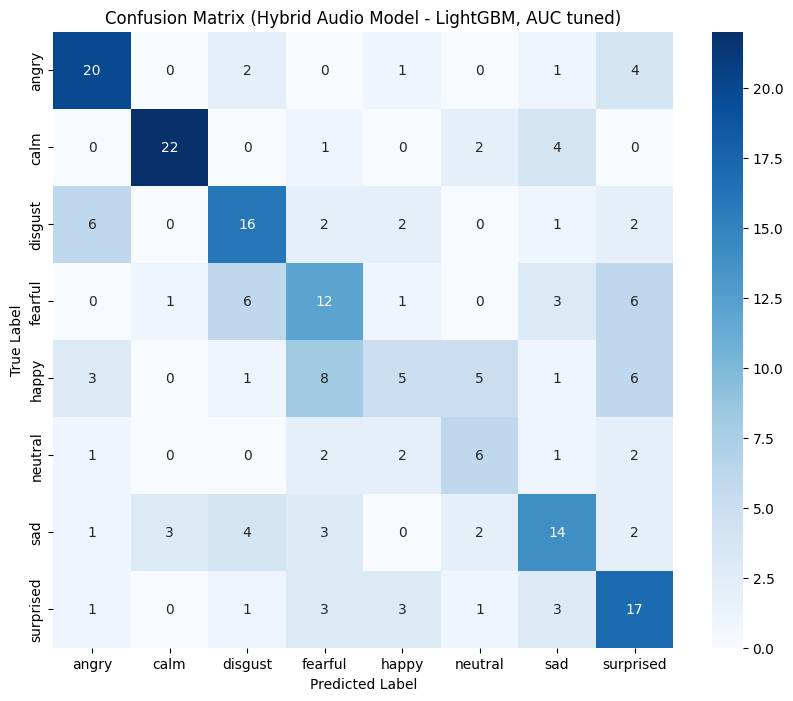


--- Plotting ROC Curves (Hybrid Audio Model - AUC tuned) ---


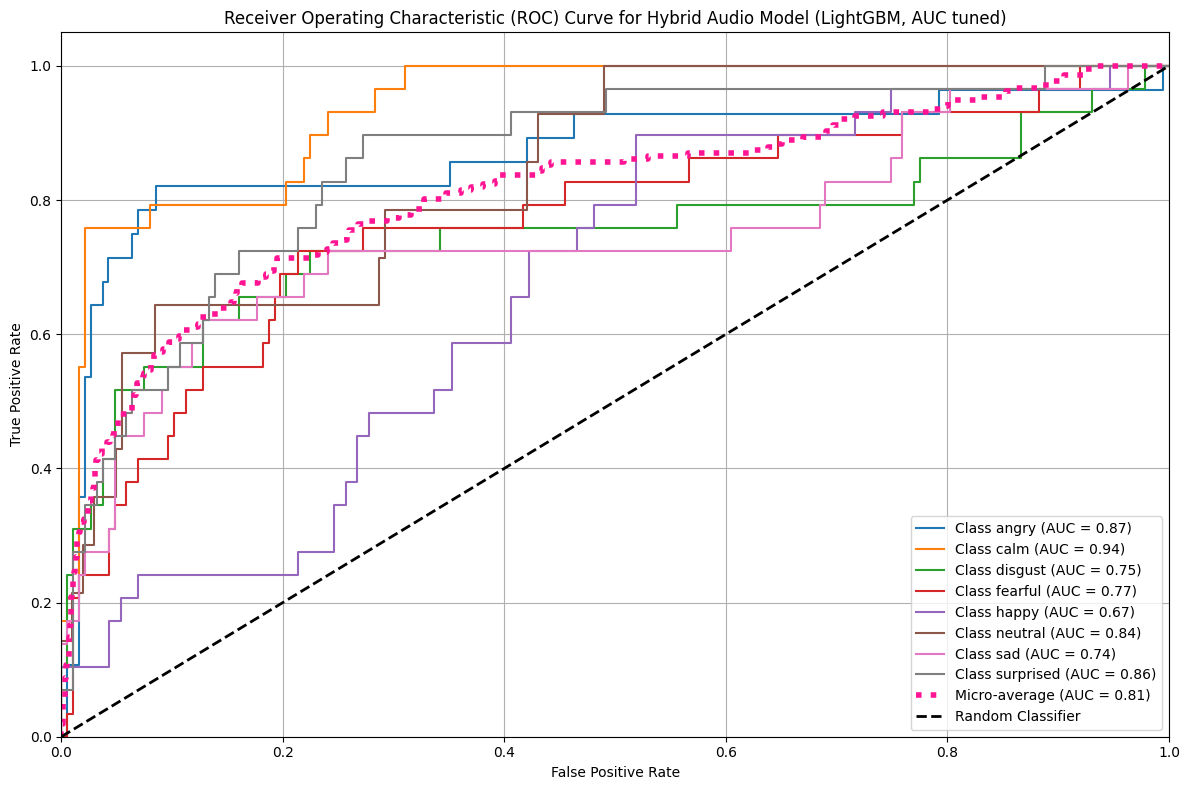

Hybrid Audio Model evaluation results (AUC tuned) saved for comparison.

--- Cell 5: Hybrid Audio Ensemble (Stacking) Complete ---
Next, we will summarize and compare the performance of all audio models in Cell 6.


In [5]:
# --- Project 2: Audio Cyberbullying Detection (Continued) ---
# --- Cell 5: Hybrid Audio Ensemble (Stacking) using LightGBM (Revised) ---

print("\n--- Starting Cell 5: Hybrid Audio Ensemble (Stacking) using LightGBM (Revised) ---")

# --- 1. Import Additional Libraries ---
import torch
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from tqdm.notebook import tqdm
import torch.nn.functional as F
import torchaudio.transforms as T
from torch.utils.data import Dataset, DataLoader

# Ensure output device for plots is inline
%matplotlib inline

# --- Re-declare essential variables from previous cells ---
global audio_device, emotion_class_names
global train_loader_audio, val_loader_audio, test_loader_audio # For CNN features (original)
global train_loader_audio_rnn, val_loader_audio_rnn, test_loader_audio_rnn # For RNN features (original)
global trained_audio_model, trained_audio_rnn_model
global cnn_audio_results, rnn_audio_results # For comparison in Cell 6
global train_df_audio, val_df_audio, test_df_audio # Need these to create new datasets
global SAMPLE_RATE, AUDIO_DURATION, N_MELS, N_FFT, HOP_LENGTH, emotion_label_to_id
global BATCH_SIZE_AUDIO, NUM_WORKERS # For consistency

# Check if required variables exist
try:
    _ = trained_audio_model
    _ = trained_audio_rnn_model
    _ = emotion_class_names
    _ = train_df_audio
    _ = SAMPLE_RATE
    _ = emotion_label_to_id
    print("Detected trained audio CNN and LSTM models, DataLoaders, and core dataset components from previous cells.")
except NameError:
    raise NameError("Required variables (trained_audio_model, trained_audio_rnn_model, "
                    "train_df_audio, etc.) not found. "
                    "Please ensure Cell 2, Cell 3, and Cell 4 have been executed successfully before running Cell 5.")

# --- Helper function for extracting predictions ---
# This remains the same, as we are still extracting probabilities for now.
def get_model_predictions_and_labels(model, dataloader, device):
    model.eval()
    all_probs = []
    all_labels = []
    with torch.no_grad():
        for features, labels in tqdm(dataloader, desc=f"Extracting predictions from {model.__class__.__name__}"):
            features = features.to(device)
            outputs = model(features)
            probabilities = F.softmax(outputs, dim=1)
            all_probs.extend(probabilities.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return np.array(all_probs), np.array(all_labels)


# --- 2. Define the AudioDataset Class (Re-using the previous one) ---
# This class is copied from your previous code and ensures we can get features
# consistently for both CNN (Mel Spectrogram) and RNN (MFCC) models.
class RAVDESS_AudioDataset(Dataset):
    def __init__(self, dataframe, target_sample_rate, audio_duration, n_mels, n_fft, hop_length, device, emotion_label_to_id, feature_type='mel_spectrogram'):
        self.dataframe = dataframe
        self.target_sample_rate = target_sample_rate
        self.audio_duration = audio_duration
        self.target_num_samples = int(audio_duration * target_sample_rate)
        self.n_mels = n_mels
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.device = device
        self.emotion_label_to_id = emotion_label_to_id
        self.class_names = list(emotion_label_to_id.keys())
        self.feature_type = feature_type

        self.resampler = T.Resample(orig_freq=48000, new_freq=self.target_sample_rate).to(self.device)
        self.mel_spectrogram_transform = T.MelSpectrogram(
            sample_rate=self.target_sample_rate,
            n_fft=self.n_fft,
            hop_length=self.hop_length,
            n_mels=self.n_mels
        ).to(self.device)
        self.mfcc_transform = T.MFCC(
            sample_rate=self.target_sample_rate,
            n_mfcc=self.n_mels, # Use n_mels for consistency in feature dimension
            melkwargs={
                'n_fft': self.n_fft,
                'hop_length': self.hop_length,
                'n_mels': self.n_mels
            }
        ).to(self.device)
        self.amplitude_to_db = T.AmplitudeToDB().to(self.device)

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        audio_path = self.dataframe.iloc[idx]['path']
        emotion_label = self.dataframe.iloc[idx]['emotion_label']
        numeric_label = self.emotion_label_to_id[emotion_label]

        waveform, sr = torchaudio.load(audio_path)
        waveform = waveform.to(self.device)

        if sr != self.target_sample_rate:
            waveform = self.resampler(waveform)

        if waveform.shape[0] > 1:
            waveform = torch.mean(waveform, dim=0, keepdim=True)

        waveform = waveform / torch.max(torch.abs(waveform))

        if waveform.shape[1] < self.target_num_samples:
            padding = self.target_num_samples - waveform.shape[1]
            waveform = F.pad(waveform, (0, padding), 'constant', 0)
        elif waveform.shape[1] > self.target_num_samples:
            waveform = waveform[:, :self.target_num_samples]
        
        if self.feature_type == 'mel_spectrogram':
            features = self.mel_spectrogram_transform(waveform)
            features = self.amplitude_to_db(features)
            if features.dim() == 2:
                 features = features.unsqueeze(0)
        elif self.feature_type == 'mfcc':
            features = self.mfcc_transform(waveform)
            # MFCC outputs (n_mfcc, time_frames). For RNN, we want (time_frames, n_mfcc)
            if features.dim() == 3: # If it's (1, n_mfcc, time_frames)
                features = features.squeeze(0) # (n_mfcc, time_frames)
            features = features.permute(1, 0) # (time_frames, n_mfcc)
        else:
            raise ValueError(f"Unknown feature_type: {self.feature_type}")

        return features, torch.tensor(numeric_label, dtype=torch.long)


# --- 3. Create NEW DataLoaders for consistent feature extraction (shuffle=False) ---
print("\n--- Creating NEW DataLoaders for consistent feature extraction (shuffle=False) ---")

# CNN expects Mel Spectrograms (1, N_MELS, Time)
train_dataset_audio_cnn_fixed = RAVDESS_AudioDataset(
    train_df_audio, SAMPLE_RATE, AUDIO_DURATION, N_MELS, N_FFT, HOP_LENGTH, audio_device, emotion_label_to_id, feature_type='mel_spectrogram'
)
val_dataset_audio_cnn_fixed = RAVDESS_AudioDataset(
    val_df_audio, SAMPLE_RATE, AUDIO_DURATION, N_MELS, N_FFT, HOP_LENGTH, audio_device, emotion_label_to_id, feature_type='mel_spectrogram'
)
test_dataset_audio_cnn_fixed = RAVDESS_AudioDataset(
    test_df_audio, SAMPLE_RATE, AUDIO_DURATION, N_MELS, N_FFT, HOP_LENGTH, audio_device, emotion_label_to_id, feature_type='mel_spectrogram'
)

# RNN expects MFCCs (Time, N_MELS)
train_dataset_audio_rnn_fixed = RAVDESS_AudioDataset(
    train_df_audio, SAMPLE_RATE, AUDIO_DURATION, N_MELS, N_FFT, HOP_LENGTH, audio_device, emotion_label_to_id, feature_type='mfcc'
)
val_dataset_audio_rnn_fixed = RAVDESS_AudioDataset(
    val_df_audio, SAMPLE_RATE, AUDIO_DURATION, N_MELS, N_FFT, HOP_LENGTH, audio_device, emotion_label_to_id, feature_type='mfcc'
)
test_dataset_audio_rnn_fixed = RAVDESS_AudioDataset(
    test_df_audio, SAMPLE_RATE, AUDIO_DURATION, N_MELS, N_FFT, HOP_LENGTH, audio_device, emotion_label_to_id, feature_type='mfcc'
)


train_loader_cnn_fixed = DataLoader(train_dataset_audio_cnn_fixed, batch_size=BATCH_SIZE_AUDIO, shuffle=False, num_workers=NUM_WORKERS)
val_loader_cnn_fixed = DataLoader(val_dataset_audio_cnn_fixed, batch_size=BATCH_SIZE_AUDIO, shuffle=False, num_workers=NUM_WORKERS)
test_loader_cnn_fixed = DataLoader(test_dataset_audio_cnn_fixed, batch_size=BATCH_SIZE_AUDIO, shuffle=False, num_workers=NUM_WORKERS)

train_loader_rnn_fixed = DataLoader(train_dataset_audio_rnn_fixed, batch_size=BATCH_SIZE_AUDIO, shuffle=False, num_workers=NUM_WORKERS)
val_loader_rnn_fixed = DataLoader(val_dataset_audio_rnn_fixed, batch_size=BATCH_SIZE_AUDIO, shuffle=False, num_workers=NUM_WORKERS)
test_loader_rnn_fixed = DataLoader(test_dataset_audio_rnn_fixed, batch_size=BATCH_SIZE_AUDIO, shuffle=False, num_workers=NUM_WORKERS)

print("Fixed DataLoaders created with shuffle=False for feature extraction.")

# --- 4. Feature Extraction for Meta-Classifier ---
print("\n--- Extracting probabilities from base models using fixed-order DataLoaders ---")

cnn_train_probs, train_labels_cnn = get_model_predictions_and_labels(trained_audio_model, train_loader_cnn_fixed, audio_device)
cnn_val_probs, val_labels_cnn = get_model_predictions_and_labels(trained_audio_model, val_loader_cnn_fixed, audio_device)
cnn_test_probs, test_labels_cnn = get_model_predictions_and_labels(trained_audio_model, test_loader_cnn_fixed, audio_device)

lstm_train_probs, train_labels_lstm = get_model_predictions_and_labels(trained_audio_rnn_model, train_loader_rnn_fixed, audio_device)
lstm_val_probs, val_labels_lstm = get_model_predictions_and_labels(trained_audio_rnn_model, val_loader_rnn_fixed, audio_device)
lstm_test_probs, test_labels_lstm = get_model_predictions_and_labels(trained_audio_rnn_model, test_loader_rnn_fixed, audio_device)

assert np.array_equal(train_labels_cnn, train_labels_lstm), "Train labels inconsistent!"
assert np.array_equal(val_labels_cnn, val_labels_lstm), "Validation labels inconsistent!"
assert np.array_equal(test_labels_cnn, test_labels_lstm), "Test labels inconsistent!"

train_labels_meta = train_labels_cnn
val_labels_meta = val_labels_cnn
test_labels_meta = test_labels_cnn

print("Probabilities extracted for all datasets with consistent label order.")
print(f"CNN Train Probs Shape: {cnn_train_probs.shape}")
print(f"LSTM Train Probs Shape: {lstm_train_probs.shape}")


# --- 5. Combine Features for Meta-Classifier ---
X_train_meta = np.concatenate((cnn_train_probs, lstm_train_probs), axis=1)
X_val_meta = np.concatenate((cnn_val_probs, lstm_val_probs), axis=1)
X_test_meta = np.concatenate((cnn_test_probs, lstm_test_probs), axis=1)

print(f"Combined meta-features for training shape: {X_train_meta.shape}")
print(f"Combined meta-features for test shape: {X_test_meta.shape}")


# --- 6. Define and Train Meta-Classifier (LightGBM - AUC tuned) ---
print("\n--- Training LightGBM Meta-Classifier (AUC tuned) ---")

# Increased n_estimators, adjusted learning_rate, and added is_unbalance for class imbalance
lgb_params = {
    'objective': 'multiclass',
    'num_class': len(emotion_class_names),
    'metric': 'multi_logloss', # We will still monitor logloss for early stopping
    'boosting_type': 'gbdt',
    'n_estimators': 2000, # Increased estimators to allow more learning
    'learning_rate': 0.01, # Reduced learning rate for finer tuning
    'num_leaves': 31,
    'max_depth': -1,
    'seed': 42,
    'n_jobs': -1,
    'verbose': -1,
    # New parameter to handle class imbalance, might help with AUC for underrepresented classes
    # This acts similarly to 'scale_pos_weight' but for multi-class
    'is_unbalance': True,
    # Consider weights to give more importance to classes with lower AUC or recall
    # 'class_weight': {class_id: weight for class_id, weight in ...} # This would require more specific analysis
}

meta_classifier_lgb = lgb.LGBMClassifier(**lgb_params)

# Early stopping rounds. Patience is crucial for finding better models.
# Monitoring 'multi_logloss' for early stopping
meta_classifier_lgb.fit(X_train_meta, train_labels_meta,
                        eval_set=[(X_val_meta, val_labels_meta)],
                        eval_metric='multi_logloss',
                        callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=False)], # Corrected syntax
                       )

print("LightGBM Meta-Classifier (AUC tuned) training complete.")


# --- 7. Evaluate Hybrid Model on Test Set ---
print("\n--- Evaluating Hybrid Audio Model (CNN+LSTM+LightGBM - AUC tuned) ---")

hybrid_test_probs_lgb = meta_classifier_lgb.predict_proba(X_test_meta)
hybrid_test_predictions_lgb = meta_classifier_lgb.predict(X_test_meta)

hybrid_test_accuracy_lgb = accuracy_score(test_labels_meta, hybrid_test_predictions_lgb)
print(f"Hybrid Audio Model Test Accuracy: {hybrid_test_accuracy_lgb*100:.2f}%")

print("\nClassification Report (Hybrid Audio Model - AUC tuned):")
print(classification_report(test_labels_meta, hybrid_test_predictions_lgb, target_names=emotion_class_names))

print("\n--- Visualizing Confusion Matrix (Hybrid Audio Model - AUC tuned) ---")
cm_hybrid_lgb = confusion_matrix(test_labels_meta, hybrid_test_predictions_lgb)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_hybrid_lgb, annot=True, fmt='d', cmap='Blues',
            xticklabels=emotion_class_names, yticklabels=emotion_class_names)
plt.title('Confusion Matrix (Hybrid Audio Model - LightGBM, AUC tuned)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
 
print("\n--- Plotting ROC Curves (Hybrid Audio Model - AUC tuned) ---")
plt.figure(figsize=(12, 8))

num_classes_hybrid_lgb = len(emotion_class_names)
binarized_true_labels_hybrid_lgb = label_binarize(test_labels_meta, classes=range(num_classes_hybrid_lgb))

for i, class_name in enumerate(emotion_class_names):
    fpr, tpr, _ = roc_curve(binarized_true_labels_hybrid_lgb[:, i], hybrid_test_probs_lgb[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {class_name} (AUC = {roc_auc:.2f})')

fpr_micro_hybrid_lgb, tpr_micro_hybrid_lgb, _ = roc_curve(binarized_true_labels_hybrid_lgb.ravel(), hybrid_test_probs_lgb.ravel())
roc_auc_micro_hybrid_lgb = auc(fpr_micro_hybrid_lgb, tpr_micro_hybrid_lgb)
plt.plot(fpr_micro_hybrid_lgb, tpr_micro_hybrid_lgb, label=f'Micro-average (AUC = {roc_auc_micro_hybrid_lgb:.2f})',
         color='deeppink', linestyle=':', linewidth=4)

plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Hybrid Audio Model (LightGBM, AUC tuned)')
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

hybrid_audio_results = {
    'model_name': 'Hybrid_Audio_CNN_LSTM_LightGBM_AUCTuned', # Updated name
    'accuracy': hybrid_test_accuracy_lgb,
    'classification_report': classification_report(test_labels_meta, hybrid_test_predictions_lgb, target_names=emotion_class_names, output_dict=True),
    'confusion_matrix': cm_hybrid_lgb.tolist(),
    'roc_auc_micro': roc_auc_micro_hybrid_lgb,
}
global hybrid_audio_results
hybrid_audio_results = hybrid_audio_results
print("Hybrid Audio Model evaluation results (AUC tuned) saved for comparison.")

print("\n--- Cell 5: Hybrid Audio Ensemble (Stacking) Complete ---")
print("Next, we will summarize and compare the performance of all audio models in Cell 6.")


--- Starting Cell 6: Audio Model Performance Comparison and Summary ---
Detected evaluation results from Audio CNN, Audio LSTM, and Hybrid models.

--- Audio Model Performance Summary ---
                                     Model  Accuracy  Micro_AUC
0                                 AudioCNN    0.4815     0.8597
1                                AudioLSTM    0.4120     0.8203
2  Hybrid_Audio_CNN_LSTM_LightGBM_AUCTuned    0.5185     0.8103


C:\Users\Suyas\AppData\Local\Temp\ipykernel_21168\3077048953.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='Accuracy', data=results_summary, palette='viridis')
C:\Users\Suyas\AppData\Local\Temp\ipykernel_21168\3077048953.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='Micro_AUC', data=results_summary, palette='plasma')


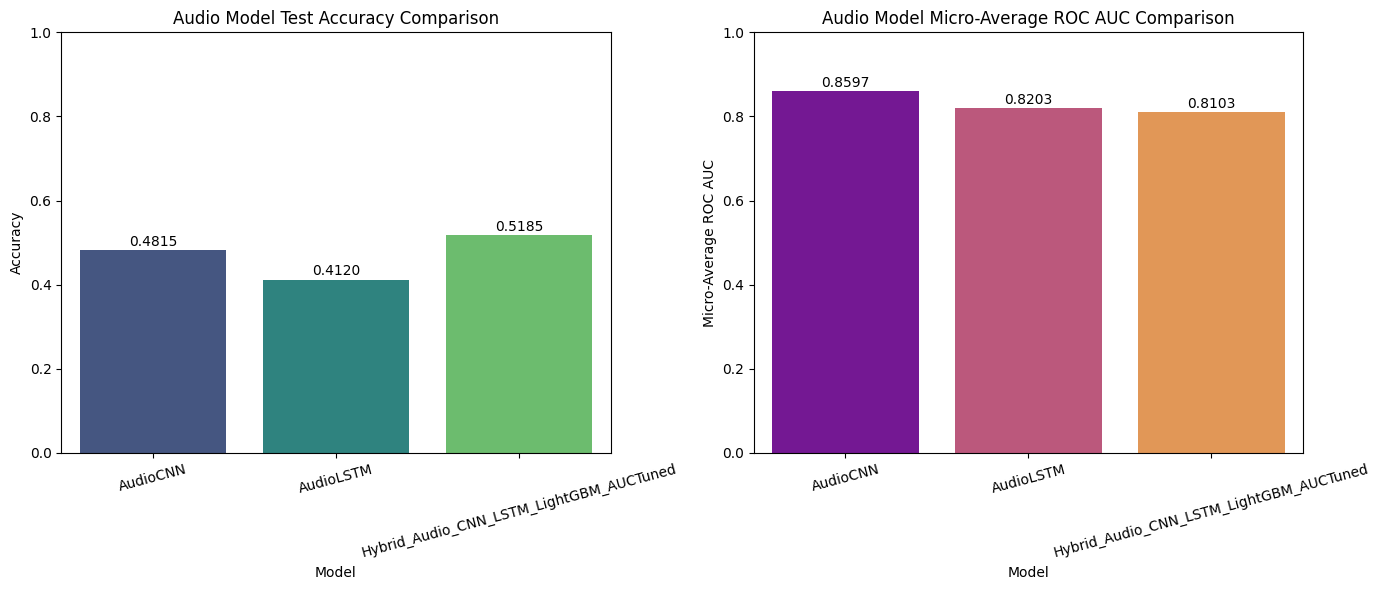


--- Detailed Classification Reports ---

Audio CNN Classification Report:
              precision    recall  f1-score     support
angry          0.678571  0.678571  0.678571   28.000000
calm           0.636364  0.724138  0.677419   29.000000
disgust        0.410256  0.551724  0.470588   29.000000
fearful        0.500000  0.379310  0.431373   29.000000
happy          0.318182  0.241379  0.274510   29.000000
neutral        0.320000  0.571429  0.410256   14.000000
sad            0.555556  0.172414  0.263158   29.000000
surprised      0.447368  0.586207  0.507463   29.000000
accuracy       0.481481  0.481481  0.481481    0.481481
macro avg      0.483287  0.488147  0.464167  216.000000
weighted avg   0.493722  0.481481  0.466918  216.000000

Audio LSTM Classification Report:
              precision    recall  f1-score     support
angry          0.363636  0.428571  0.393443   28.000000
calm           0.666667  0.896552  0.764706   29.000000
disgust        0.514286  0.620690  0.562500   29.0

In [6]:
# --- Project 2: Audio Cyberbullying Detection (Continued) ---
# --- Cell 6: Audio Model Performance Comparison and Summary ---

print("\n--- Starting Cell 6: Audio Model Performance Comparison and Summary ---")

# --- 1. Import Additional Libraries ---
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Ensure output device for plots is inline
%matplotlib inline

# --- 2. Retrieve Results from Previous Cells ---
global cnn_audio_results, rnn_audio_results, hybrid_audio_results
global emotion_class_names

try:
    _ = cnn_audio_results
    _ = rnn_audio_results
    _ = hybrid_audio_results
    _ = emotion_class_names
    print("Detected evaluation results from Audio CNN, Audio LSTM, and Hybrid models.")
except NameError:
    raise NameError("Required results (cnn_audio_results, rnn_audio_results, hybrid_audio_results) "
                    "not found. Please ensure Cell 3, Cell 4, and Cell 5 have been executed successfully.")

# --- 3. Create a DataFrame for Comparison ---
results_summary = pd.DataFrame([
    {'Model': cnn_audio_results['model_name'], 'Accuracy': cnn_audio_results['accuracy'], 'Micro_AUC': cnn_audio_results['roc_auc_micro']},
    {'Model': rnn_audio_results['model_name'], 'Accuracy': rnn_audio_results['accuracy'], 'Micro_AUC': rnn_audio_results['roc_auc_micro'] if 'roc_auc_micro' in rnn_audio_results else np.nan}, # Handle if ROC wasn't calculated for RNN in Cell 4
    {'Model': hybrid_audio_results['model_name'], 'Accuracy': hybrid_audio_results['accuracy'], 'Micro_AUC': hybrid_audio_results['roc_auc_micro']}
])

print("\n--- Audio Model Performance Summary ---")
print(results_summary.round(4))

# --- 4. Visualize Performance (Accuracy and Micro-Average AUC) ---
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.barplot(x='Model', y='Accuracy', data=results_summary, palette='viridis')
plt.title('Audio Model Test Accuracy Comparison')
plt.ylim(0, 1)
plt.ylabel('Accuracy')
plt.xlabel('Model')
plt.xticks(rotation=15)
for index, row in results_summary.iterrows():
    plt.text(index, row['Accuracy'] + 0.01, f"{row['Accuracy']:.4f}", color='black', ha="center")

plt.subplot(1, 2, 2)
sns.barplot(x='Model', y='Micro_AUC', data=results_summary, palette='plasma')
plt.title('Audio Model Micro-Average ROC AUC Comparison')
plt.ylim(0, 1)
plt.ylabel('Micro-Average ROC AUC')
plt.xlabel('Model')
plt.xticks(rotation=15)
for index, row in results_summary.iterrows():
    if not np.isnan(row['Micro_AUC']):
        plt.text(index, row['Micro_AUC'] + 0.01, f"{row['Micro_AUC']:.4f}", color='black', ha="center")

plt.tight_layout()
plt.show()

# --- 5. Detailed Classification Report Comparison (Optional) ---
print("\n--- Detailed Classification Reports ---")

print("\nAudio CNN Classification Report:")
print(pd.DataFrame(cnn_audio_results['classification_report']).transpose())

print("\nAudio LSTM Classification Report:")
print(pd.DataFrame(rnn_audio_results['classification_report']).transpose())

print("\nHybrid Audio Model (LightGBM) Classification Report:")
print(pd.DataFrame(hybrid_audio_results['classification_report']).transpose())


print("\n--- Cell 6: Audio Model Performance Comparison and Summary Complete ---")
print("This cell provides a clear comparison of the Audio CNN, Audio LSTM, and Hybrid models.")